In [116]:
import json
import os
import pandas as pd
from plotnine import *

In [6]:
METRICS_DIR = '/home/pmccarthy/projects/embedding_study/metrics'

In [10]:
! ls {METRICS_DIR}

93bebc15e98df1fc5eab83cc89ef1090f7b98c3e_add_first_pass_at_testing_code


In [98]:
def read_single(obj, filename):
    df_obj = {}
    similarities = {}
    
    for k in obj.keys():
        
        if 'similarity' in k:
            similarities[k] = pd.DataFrame(obj[k])
            
    
        elif k == 'benchmarks':
            benchmarks = pd.DataFrame(obj[k]).assign(filename = filename)
            
    df_obj['similarities'] = pd.concat(similarities)
    df_obj['benchmarks'] = benchmarks
    df_obj['filename'] = filename
    return df_obj

In [99]:
metrics = {}
runs = os.listdir(METRICS_DIR)

for dirname in runs:
    print(dirname)
    metrics[dirname] = {}
    
    for file in os.listdir(os.path.join(METRICS_DIR,dirname)):
        file_path = os.path.join(METRICS_DIR,dirname,file)
        with open(file_path,'r') as f:
            file_name = ".".join(file.split('.')[:-1])
            metrics[dirname][file] = read_single(json.loads(json.load(f)), file_name)


93bebc15e98df1fc5eab83cc89ef1090f7b98c3e_add_first_pass_at_testing_code


In [120]:
benchmarks = []

for dirname in metrics.keys():
    for file in metrics[dirname]:
        benchmarks.append(metrics[dirname][file]['benchmarks'])

benchmark_df =(
    pd.concat(benchmarks)
    .assign(metric_rank = lambda x: x.groupby(['test','metric'])['value'].rank(ascending=False))
    .sort_values('metric_rank')    
    .assign(short_name = lambda x: x['filename'].str.split('_').apply(lambda y: "_".join([z for z in y[:-1]])))
    .drop('filename',axis=1)
)
print(benchmark_df.to_markdown())


|    | test       | metric       |     value |   metric_rank | short_name     |
|---:|:-----------|:-------------|----------:|--------------:|:---------------|
|  0 | wordsim353 | pearson_cor  | 0.623877  |             1 | google_news    |
|  1 | wordsim353 | spearman_cor | 0.658922  |             1 | google_news    |
|  2 | simlex999  | pearson_cor  | 0.447171  |             1 | google_news    |
|  3 | simlex999  | spearman_cor | 0.436079  |             1 | google_news    |
|  4 | google     | accuracy     | 0.740145  |             1 | google_news    |
|  0 | wordsim353 | pearson_cor  | 0.573458  |             2 | gensim_default |
|  1 | wordsim353 | spearman_cor | 0.588149  |             2 | gensim_default |
|  2 | simlex999  | pearson_cor  | 0.295042  |             2 | gensim_default |
|  3 | simlex999  | spearman_cor | 0.28      |             2 | gensim_default |
|  4 | google     | accuracy     | 0.1823    |             2 | gensim_default |
|  0 | wordsim353 | pearson_cor  | 0.217

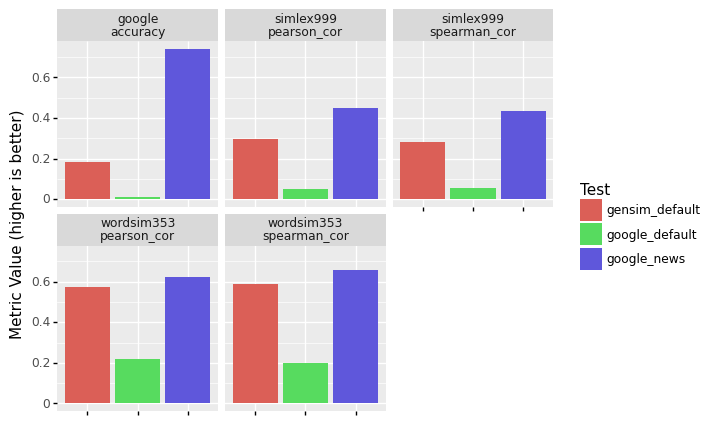

<ggplot: (8763889154681)>

In [129]:
(
    ggplot(benchmark_df, aes(x='short_name',y='value', fill='short_name'))
    + geom_bar(stat='identity')
    + facet_wrap(['test','metric'])
    + labs(fill="Test",x="",y="Metric Value (higher is better)")
    + theme(axis_text_x=element_blank())
)

In [133]:
similarities = []
for dirname in metrics.keys():
    for file in metrics[dirname]:
        file_shortname = "_".join(file.split('_')[:-1])
        similarities.append(metrics[dirname][file]['similarities'].assign(file=file_shortname))

In [159]:
(
    pd.concat(similarities)
    .reset_index()
    .rename(columns={'level_0':'test','level_1':'rank'})
    .query('rank <= 3')
    .drop('cosine_dist',axis=1)
    .pivot(index=['file','rank'],columns='test')
)

word                                        \
test                boat_similarity december_similarity french_similarity   
file           rank                                                         
gensim_default 0              boats            november             dutch   
               1             vessel            february           italian   
               2               ship               march            german   
               3            steamer             january           spanish   
google_default 0           dialogue            november            korean   
               1             artist                july              tank   
               2         revolution               march         beautiful   
               3              1950s            february           derived   
google_news    0              boats           september            French   
               1           sailboat               april            france   
               2          motorboat             october             dutch   
               3       fishing_boat            february           italian   

                                       
test                street_similarity  
file           rank                    
gensim_default 0               avenue  
               1            boulevard  
               2           piccadilly  
               3                 lane  
google_default 0               bishop  
               1                    h  
               2              antonio  
               3                 earl  
google_news    0              streets  
               1             sidewalk  
               2            boulevard  
               3                alley

In [145]:
pd.melt?